Link to colab: https://colab.research.google.com/drive/1tvDOxvfDloqGd6h4lQPxS0IgyVepAdcQ?usp=sharing

In [ ]:
!wget -O boards_hq_75k.tar 'https://drive.google.com/u/0/uc?id=1pRSmkge5DHocNz3rZCjFek38YFO8-Ze5&confirm=t'
!tar -xf boards_hq_75k.tar

!mv boards_hq data
!pip install chess

--2023-06-13 06:01:53--  https://drive.google.com/u/0/uc?id=1pRSmkge5DHocNz3rZCjFek38YFO8-Ze5&confirm=t
Resolving drive.google.com (drive.google.com)... 172.217.203.102, 172.217.203.138, 172.217.203.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1pRSmkge5DHocNz3rZCjFek38YFO8-Ze5&confirm=t [following]
--2023-06-13 06:01:53--  https://drive.google.com/uc?id=1pRSmkge5DHocNz3rZCjFek38YFO8-Ze5&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/thqiv3k4hk2v7ea32mii9uki0tt8glrq/1686636075000/18334911380517025247/*/1pRSmkge5DHocNz3rZCjFek38YFO8-Ze5?uuid=74c55100-74fd-4a7c-a650-6cb71b4fcc80 [following]
--2023-06-13 06:01:53--  https://doc-0s-bo-docs.googleusercontent.com/docs/securesc/ha0ro937g

In [ ]:
#@title Setup - Get ChessGNN repo (wait until session restarts)
def get_repo_and_install():
    import subprocess

    assert subprocess.getstatusoutput(f"git clone --depth=1 https://github.com/marcinz99/ChessGNN.git")[0] == 0
    assert subprocess.getstatusoutput(f"pip install -e ChessGNN/")[0] == 0
    exit()

get_repo_and_install()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import subprocess
import chess
import os
import gc
import itertools
from tensorflow.data import Dataset
from chessgnn.graphchess.data_ingestion import get_dataset, select_targets, get_squarewise_features, prepare_features
from chessgnn.graphchess.architecture import input_block, full_block, regular_mlp_head, softmax_mlp_head
from chessgnn.graphchess.helpers import load_model
from chessgnn.chess_utils.data_preparation import move_list_encode
from chessgnn.chess_utils.translations import piece_encoding_from_fen_code, piece_encoding_to_fen_code, coo_graph_from_fen_code

pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 72
DRIVE_PATH = "/content/drive/MyDrive/Praca magisterska/Colabs 4 - Final work/Models{}/"

def run_cmd(cmd):
    subprocess.check_output([cmd], shell=True)

In [ ]:
path = DRIVE_PATH.format('2')
model_ver = 30

run_cmd(f'cp "{path}graphchess_{model_ver}.h5" .')
model = load_model(f"graphchess_{model_ver}.h5")

model = tf.keras.models.Model(
    inputs={
        'pos_feats': model.get_layer('pos_feats_input').output,
        'glob_feats': model.get_layer('glob_feats_input').output,
        'coo_graph': model.get_layer('coo_graph_input').output,
        'legal_moves': model.get_layer('legal_moves_input').output,
    },
    outputs={
        'next_move': model.get_layer('next_move').output,
        'final_result': model.get_layer('final_result').output,
    },
)
model.summary(line_length=180, positions=[0.5, 0.65, 0.725, 1.0])

Model: "model"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                             Output Shape               Param #      Connected to                                      
 pos_feats_input (InputLayer)                                                             [(1, None, 12)]            0            []                                                
                                                                                                                                                                                    
 coo_graph_input (InputLayer)                                                             [(1, None, 2)]             0            []                                                
                                                                                

In [ ]:
def uci_move_to_graph_coo(uci_notation: str) -> np.ndarray:
    """
    This function takes UCI move and produces the equivalent graph edge as a single entry to of graph COO-rdinate
    representation (this edge here is assumed to be directed).
    """
    # The code below is a short form of: 8 * (8 - <pos_number>) + ord(<pos_letter>) - ord('a')
    node_from = ord(uci_notation[0]) - 8 * int(uci_notation[1]) - 33
    node_to = ord(uci_notation[2]) - 8 * int(uci_notation[3]) - 33
    return np.array([node_from, node_to])


def graph_coo_to_uci_move(graph_coo: np.ndarray) -> str:
    node_from, node_to = graph_coo
    node_from = chr(97 + (node_from % 8)) + str((71 - node_from) // 8)
    node_to = chr(97 + (node_to % 8)) + str((71 - node_to) // 8)
    uci_notation = node_from + node_to
    return uci_notation


np.testing.assert_array_equal(uci_move_to_graph_coo("d4d5"), np.array([35, 27]))
np.testing.assert_array_equal(uci_move_to_graph_coo("h1a8"), np.array([63, 0]))
np.testing.assert_array_equal(uci_move_to_graph_coo("b8b1"), np.array([1, 57]))

np.testing.assert_array_equal(graph_coo_to_uci_move(np.array([35, 27])), "d4d5")
np.testing.assert_array_equal(graph_coo_to_uci_move(np.array([63, 0])), "h1a8")
np.testing.assert_array_equal(graph_coo_to_uci_move(np.array([1, 57])), "b8b1")

for i in range(64):
    for j in range(64):
        np.testing.assert_array_equal(uci_move_to_graph_coo(graph_coo_to_uci_move([i, j])), np.array([i, j]))

In [ ]:
@tf.function(reduce_retracing=True)
def predict(inp):
    return model(inp)


def evaluate_and_assess(predict_func, feats_input, verbose=True):
    results = predict_func({i: feats_input[i] for i in ['pos_feats', 'glob_feats', 'coo_graph', 'legal_moves']})

    preferred_moves = sorted(zip(
        feats_input['coo_graph'][0].numpy().tolist(),
        feats_input['legal_moves'][0].numpy() * results['next_move'][0].numpy()
    ), key=lambda x: x[1], reverse=True)

    if verbose:
        print(f"Sum of probas assigned to legal moves: {sum(map(lambda x: x[1], preferred_moves)) :.4f}")

    actual_move = graph_coo_to_uci_move(tf.boolean_mask(feats_input['coo_graph'], feats_input['next_move'])[0].numpy())
    if verbose:
        print(f"Actual move: {actual_move}")

    piece_types = np.sum(feats_input['pos_feats'][0, :, :6] * np.arange(1, 7), axis=-1).astype(int)

    next_move = pd.DataFrame(preferred_moves, columns=['coo', 'proba'])
    next_move['proba'] /= next_move['proba'].sum()
    next_move['uci'] = next_move['coo'].apply(graph_coo_to_uci_move)
    next_move['piece_type'] = next_move['coo'].apply(lambda x: piece_types[x[0]])
    next_move['is_promotion'] = next_move.apply(
        lambda x: (x['piece_type'] == 6)
            and ((x['uci'][1] == '7' and x['uci'][3] == '8') or (x['uci'][1] == '2' and x['uci'][3] == '1')),
        axis='columns')
    next_move['uci'] = next_move['uci'] + next_move['is_promotion'].apply(lambda x: 'q' if x else '')

    next_move['is_actual'] = (next_move['uci'].apply(lambda x: x[:4]) == actual_move)

    return next_move.head(10)

In [ ]:
def get_feats_input(board, state_rep=0):
    feats_input = {
        'pos_feats': piece_encoding_from_fen_code(board.board_fen())[tf.newaxis, ...],
        'coo_graph': coo_graph_from_fen_code(board.board_fen())[tf.newaxis, ...],
    }
    feats_input['legal_moves'] = tf.cast(tf.reduce_any(tf.reduce_all(
        feats_input['coo_graph'][0][:, np.newaxis, :]
            == tf.cast(move_list_encode(board.generate_legal_moves()).reshape(-1, 2) - 1, dtype=tf.int32),
        axis=-1), axis=-1), dtype=tf.int32
    )[tf.newaxis, ...]

    fen_split = board.fen().split()

    glob_feats = tf.cast([
        fen_split[1] == 'w', fen_split[1] == 'b',
        'K' in fen_split[2], 'Q' in fen_split[2], 'k' in fen_split[2], 'q' in fen_split[2],
    ], dtype=tf.float32)

    glob_feats = tf.concat([glob_feats, [0.04 * float(fen_split[4]), 0.5 * state_rep]], axis=0)[tf.newaxis, :]
    feats_input['glob_feats'] = glob_feats

    return feats_input

In [ ]:
def evaluate(predict_func, feats_input, verbose=True, n=5, return_final_res_probas=False):
    results = predict_func({i: feats_input[i] for i in ['pos_feats', 'glob_feats', 'coo_graph', 'legal_moves']})

    preferred_moves = list(zip(
        feats_input['coo_graph'][0].numpy().tolist(),
        results['next_move'][0].numpy(),
    ))

    if verbose:
        print(f"Sum of probas assigned to legal moves: {sum(map(lambda x: x[1], preferred_moves)) :.4f}")

    piece_types = np.sum(feats_input['pos_feats'][0, :, :6] * np.arange(1, 7), axis=-1).astype(int)

    next_move = pd.DataFrame(preferred_moves, columns=['coo', 'proba'])
    next_move['proba'] /= next_move['proba'].sum()
    next_move['uci'] = next_move['coo'].apply(graph_coo_to_uci_move)
    next_move['piece_type'] = next_move['coo'].apply(lambda x: piece_types[x[0]])
    next_move['is_promotion'] = next_move.apply(
        lambda x: (x['piece_type'] == 6)
            and ((x['uci'][1] == '7' and x['uci'][3] == '8') or (x['uci'][1] == '2' and x['uci'][3] == '1')),
        axis='columns')
    next_move['uci'] = next_move['uci'] + next_move['is_promotion'].apply(lambda x: 'q' if x else '')

    next_move = next_move[feats_input['legal_moves'][0].numpy() == 1]
    next_move = next_move.sort_values('proba', ascending=False).reset_index(drop=True)

    if return_final_res_probas:
        return next_move.head(n), results['final_result'][0]
    else:
        return next_move.head(n)

In [ ]:
def initialize_board_from_features(input_feats):
    b = chess.Board()
    b.set_board_fen(piece_encoding_to_fen_code(input_feats['pos_feats'][0]))

    # If black starts, perform an empty move to change the moving side
    if input_feats['glob_feats'][0, 1].numpy() > 0.5:
        b.push_uci('0000')

    return b

In [ ]:
ds = get_dataset(data_file_path='data/boards_0000000.parquet', shuffle=True)
ds = ds.map(prepare_features)
ds = ds.batch(1)

In [ ]:
for feats in ds.take(1):
    pass

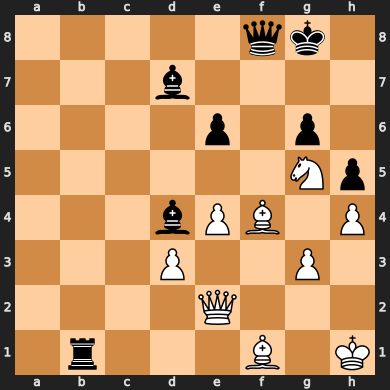

Black moves


In [ ]:
b = initialize_board_from_features(feats)
initial_fen = b.fen()
display(b)
print("White moves" if b.turn else "Black moves")

In [ ]:
proba, value = evaluate(predict, get_feats_input(b), verbose=True, n=5, return_final_res_probas=True)
display(proba)
display(value.numpy())

Sum of probas assigned to legal moves: 1.0000


,coo,proba,uci,piece_type,is_promotion
0,"[57, 61]",0.131135,b1f1,1,False
1,"[5, 37]",0.099621,f8f4,4,False
2,"[20, 28]",0.068984,e6e5,6,False
3,"[5, 33]",0.052428,f8b4,4,False
4,"[35, 42]",0.050262,d4c3,3,False


array([0.17401133, 0.27495453, 0.55103415], dtype=float32)

### Direct prediction

In [ ]:
b = initialize_board_from_features(feats)
initial_fen = b.fen()

In [ ]:
i = 0
fens_base_history = []
gameplay = []

while True:
    current_fen_base = ' '.join(b.fen().split(' ')[:4])
    repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
    fens_base_history += [current_fen_base]

    probas, values = evaluate(
        predict_func=predict,
        feats_input=get_feats_input(b, state_rep=repeats),
        verbose=False, n=5, return_final_res_probas=True)
    probas = probas[['uci', 'proba']]

    if probas.shape[0] == 0 or i > 100:
        break

    if repeats == 0 or probas.shape[0] == 1:
        next_move_uci = probas.loc[0, 'uci']
    else:
        next_move_uci = np.random.choice(probas['uci'][1:], p=(probas['proba'][1:] / probas['proba'][1:].sum()).values)

    gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
    b.push_uci(next_move_uci)
    i += 1
    display(b)

display(pd.DataFrame([{
    'result': b.result(),
    'len': len(gameplay),
    'game': ' '.join(gameplay),
    'initial_fen': initial_fen,
}]))

### Search-based prediction

In [ ]:
def minimax_search(board, origin_color, joint_proba=1.0, proba_limit=1e-2):
    """
    Returns tuple (value, number of evals)
    """
    res = board.result()
    n_evals = 0

    if res != '*':
        if res == '1/2-1/2':
            return (0.25, n_evals)
        elif res == '1-0':
            return (1.0, n_evals) if origin_color == 'w' else (-1.0, n_evals)
        elif res == '0-1':
            return (1.0, n_evals) if origin_color == 'b' else (-1.0, n_evals)

    else:
        probas, values = evaluate(
            predict_func=predict,
            feats_input=get_feats_input(b, state_rep=repeats),
            verbose=False, n=8, return_final_res_probas=True)
        n_evals += 1

        probas = probas[['uci', 'proba']]
        probas['proba'] *= joint_proba
        probas = probas[probas['proba'] > proba_limit]

        if probas.shape[0] == 0:
            return (values[0].numpy(), n_evals) if origin_color == 'w' else (values[2].numpy(), n_evals)

        else:
            v_list = []
            for _, (uci, proba) in probas.iterrows():
                board.push_uci(uci)
                v, evals_rec = minimax_search(board, origin_color, joint_proba=proba, proba_limit=proba_limit)
                board.pop()

                v_list += [v]
                n_evals += evals_rec

            if (board.turn and origin_color == 'w') or (not board.turn and origin_color == 'b'):
                return (max(v_list), n_evals)
            else:
                return (min(v_list), n_evals)

In [ ]:
b = initialize_board_from_features(feats)
initial_fen = b.fen()

'Number of evaluations: 101'

[('f8a3', 0.5419769),
 ('f8c5', 0.48226488),
 ('e6e5', 0.45295343),
 ('d4c3', 0.434459),
 ('f8f6', 0.42519054),
 ('f8b4', 0.39235112),
 ('b1f1', 0.24579842),
 ('f8f4', 0.23112066)]

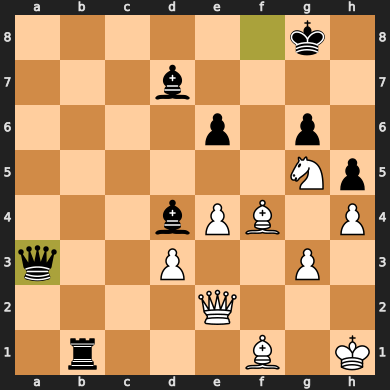

'Number of evaluations: 89'

[('e4e5', 0.23869675),
 ('h1h2', 0.18907568),
 ('h1g2', 0.17100444),
 ('g5f3', 0.15666562),
 ('e2g2', 0.12691215),
 ('g5e6', 0.07583305),
 ('e2d2', 0.07562472),
 ('e2h2', 0.038293473)]

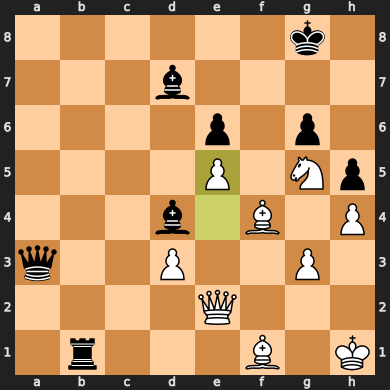

'Number of evaluations: 102'

[('a3c3', 0.48309726),
 ('d4c3', 0.43056557),
 ('a3a1', 0.3682904),
 ('b1f1', 0.34539405),
 ('d4e5', 0.34216404),
 ('a3b2', 0.26619262),
 ('b1b2', 0.1824452),
 ('a3d3', 0.085150905)]

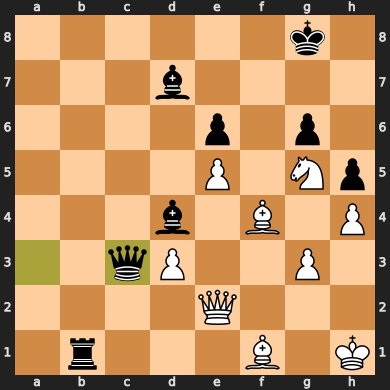

'Number of evaluations: 108'

[('h1h2', 0.1742893),
 ('e2f3', 0.14655337),
 ('h1g2', 0.13623449),
 ('g5e4', 0.13387172),
 ('e2g2', 0.11708495),
 ('e2e4', 0.10528817),
 ('g5e6', 0.104338236),
 ('g5f3', 0.077766344)]

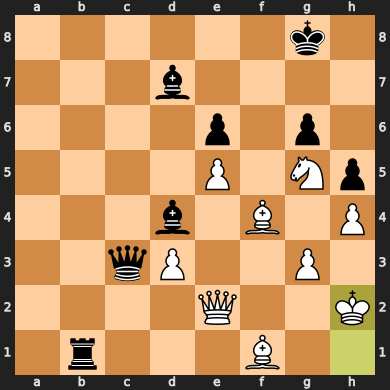

'Number of evaluations: 110'

[('b1e1', 0.49675062),
 ('b1f1', 0.4813107),
 ('c3a1', 0.38396445),
 ('c3e1', 0.37736067),
 ('d4e5', 0.3002092),
 ('c3b2', 0.2582219),
 ('b1b2', 0.2100628),
 ('c3d3', 0.082769714)]

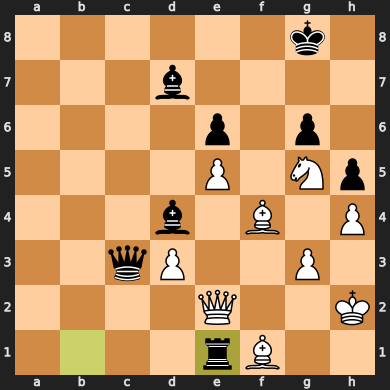

'Number of evaluations: 132'

[('e2f3', 0.17651223),
 ('e2g2', 0.17197569),
 ('e2e4', 0.16251773),
 ('g5e4', 0.11513289),
 ('e2e1', 0.06862847),
 ('e2h5', 0.05931686),
 ('f1g2', 0.04830513),
 ('g5e6', 0.024769178)]

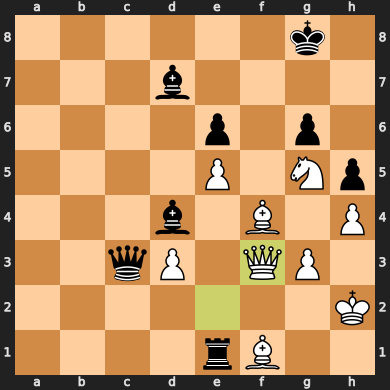

'Number of evaluations: 109'

[('c3c2', 0.5597232),
 ('c3b2', 0.513866),
 ('d4e5', 0.45982674),
 ('c3a1', 0.3797693),
 ('e1e5', 0.37837133),
 ('c3c5', 0.1902084),
 ('e1f1', 0.15343781),
 ('c3d3', 0.05405909)]

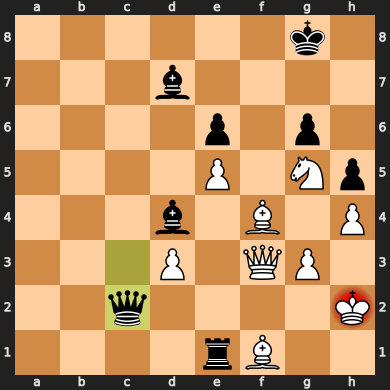

'Number of evaluations: 139'

[('f1g2', 0.20150013),
 ('h2h3', 0.19973841),
 ('h2h1', 0.19472997),
 ('f3g2', 0.14930181),
 ('f3f2', 0.119804084),
 ('f1e2', 0.040938716),
 ('f4d2', 0.03632719),
 ('f3e2', 0.0033012382)]

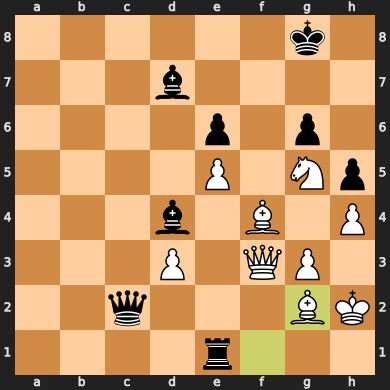

'Number of evaluations: 108'

[('d4e5', 0.49401665),
 ('e1g1', 0.439354),
 ('c2c3', 0.40521497),
 ('e1e5', 0.25227392),
 ('c2d1', 0.24932948),
 ('c2f2', 0.23882465),
 ('c2b1', 0.19167319),
 ('c2d3', 0.07211447)]

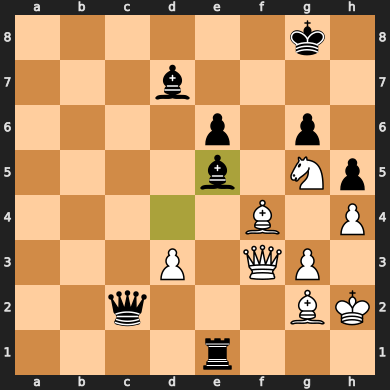

'Number of evaluations: 114'

[('f4e5', 0.3988997),
 ('f3a8', 0.34877762),
 ('g5f7', 0.17843711),
 ('f3h5', 0.13981293),
 ('g5e6', 0.1334764),
 ('d3d4', 0.104138404),
 ('g5e4', 0.0968507),
 ('f3b7', 0.09585538)]

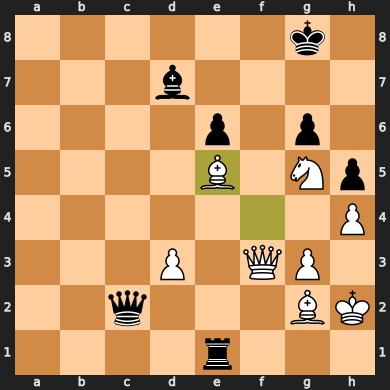

'Number of evaluations: 117'

[('c2g2', 0.037520256),
 ('e1e5', -1.0),
 ('e1g1', -1.0),
 ('c2d3', -1.0),
 ('c2d2', -1.0),
 ('c2d1', -1.0),
 ('e1d1', -1.0),
 ('e1c1', -1.0)]

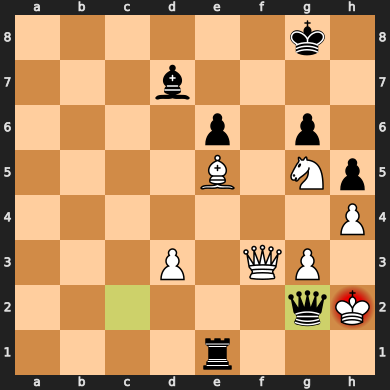

'Number of evaluations: 147'

[('h2g2', 0.86081743), ('f3g2', 0.53930396)]

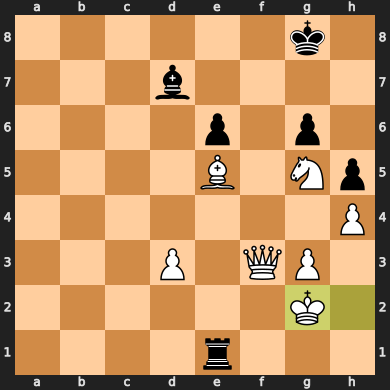

'Number of evaluations: 151'

[('d7a4', 0.032516982),
 ('d7e8', 0.029268375),
 ('d7c8', 0.0074176136),
 ('e1g1', 0.00033906224),
 ('e1e5', -1.0),
 ('e1c1', -1.0),
 ('e1b1', -1.0),
 ('d7b5', -1.0)]

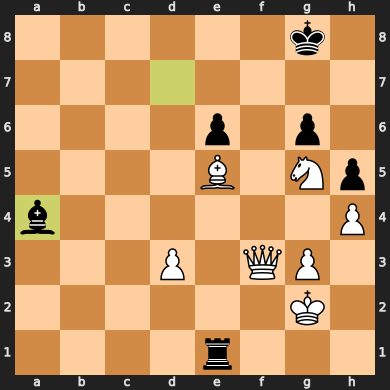

'Number of evaluations: 83'

[('f3f7', 1.0),
 ('g5e6', 0.97896624),
 ('d3d4', 0.9566074),
 ('e5f6', 0.945127),
 ('g5e4', 0.9254705),
 ('e5d6', 0.9205031),
 ('f3f6', 0.9007494),
 ('f3f8', 0.20542425)]

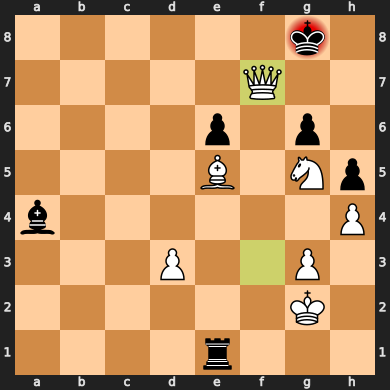

,result,len,game,initial_fen
0,1-0,14,B1.Qa3 W1.e5 B2.Qc3 W2.Kh2 B3.Re1 W3.Qf3 B4.Qc...,5qk1/3b4/4p1p1/6Np/3bPB1P/3P2P1/4Q3/1r3B1K b -...


In [ ]:
i = 0
fens_base_history = []
gameplay = []

while True:
    current_fen_base = ' '.join(b.fen().split(' ')[:4])
    repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
    fens_base_history += [current_fen_base]

    current_color = 'w' if b.turn else 'b'
    n_evals = 1

    probas, _ = evaluate(
        predict_func=predict,
        feats_input=get_feats_input(b, state_rep=repeats),
        verbose=False, n=8, return_final_res_probas=True)
    probas = probas[['uci', 'proba']]

    if probas.shape[0] == 0 or i > 20:
        break

    values = []

    for _, (uci, proba) in probas.iterrows():
        b.push_uci(uci)
        v, count = minimax_search(b, origin_color=current_color, joint_proba=proba, proba_limit=2e-3)
        values += [(uci, v)]
        n_evals += count
        b.pop()

    values = sorted(values, key=lambda x: x[1], reverse=True)
    display(f"Number of evaluations: {n_evals}")
    display(values)
    next_move_uci = values[0][0]

    gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
    b.push_uci(next_move_uci)
    i += 1
    display(b)

display(pd.DataFrame([{
    'result': b.result(),
    'len': len(gameplay),
    'game': ' '.join(gameplay),
    'initial_fen': initial_fen,
}]))

# Stockfish

In [ ]:
!wget https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip && \
 unzip stockfish_14_linux_x64_popcnt.zip stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt
!pip install stockfish
from stockfish import Stockfish
import timeit

--2023-06-13 07:06:57--  https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip
Resolving stockfishchess.org (stockfishchess.org)... 172.67.80.249, 104.25.158.9, 104.25.159.9, ...
Connecting to stockfishchess.org (stockfishchess.org)|172.67.80.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28531469 (27M) [application/zip]
Saving to: ‘stockfish_14_linux_x64_popcnt.zip’

stockfish_14_linux_ 100%[===================>]  27.21M  10.7MB/s    in 2.5s    

2023-06-13 07:07:00 (10.7 MB/s) - ‘stockfish_14_linux_x64_popcnt.zip’ saved [28531469/28531469]

Archive:  stockfish_14_linux_x64_popcnt.zip
  inflating: stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
stock = Stockfish(path="/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")

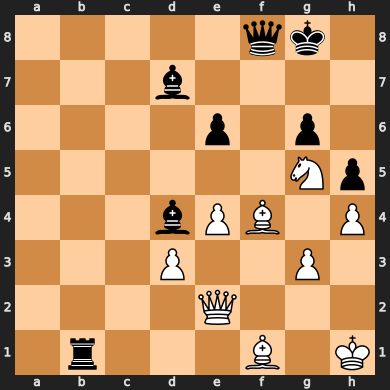

GraphChess - B, Stockfish - W


In [ ]:
b = initialize_board_from_features(feats)
initial_fen = b.fen()
display(b)

if b.turn:
    print("GraphChess - W, Stockfish - B")
else:
    print("GraphChess - B, Stockfish - W")

In [ ]:
stock.set_elo_rating(1000)

'Number of evaluations: 131'

[('e6e5', 0.65473074),
 ('f8a3', 0.5419769),
 ('d4c3', 0.5189042),
 ('f8c5', 0.48226488),
 ('f8f6', 0.42519054),
 ('f8b4', 0.39235112),
 ('b1f1', 0.24579842),
 ('f8f4', 0.23112066)]

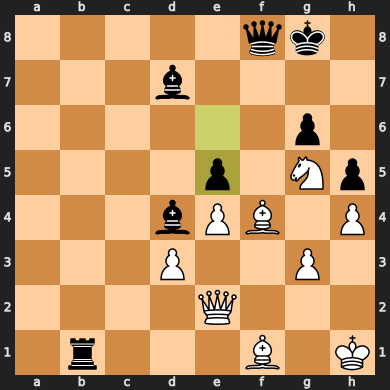

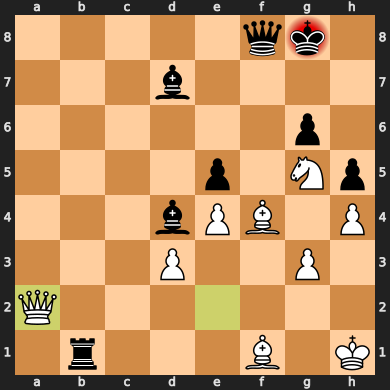

'Number of evaluations: 222'

[('g8g7', 0.4002777),
 ('g8h8', 0.3658858),
 ('d7e6', 0.1384121),
 ('b1b3', 0.11402517),
 ('f8f7', 0.047293726)]

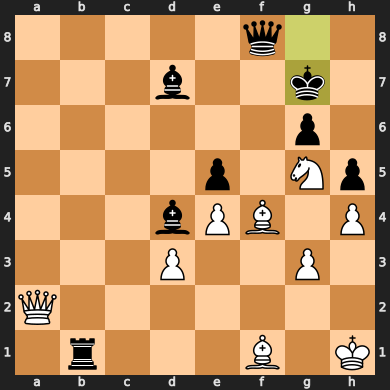

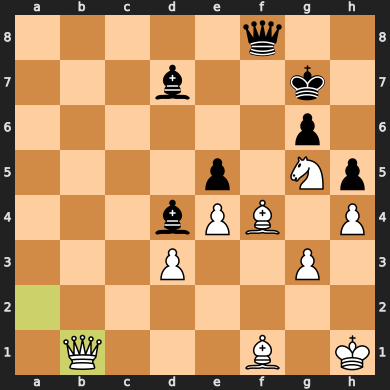

'Number of evaluations: 208'

[('e5f4', 0.3227782),
 ('f8a3', 0.20440108),
 ('f8f6', 0.16286848),
 ('f8c5', 0.12922157),
 ('d4c3', 0.09819899),
 ('d7g4', 0.094027035),
 ('d7f5', 0.06535614),
 ('f8f4', 0.029060699)]

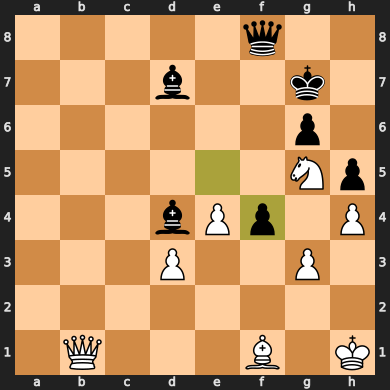

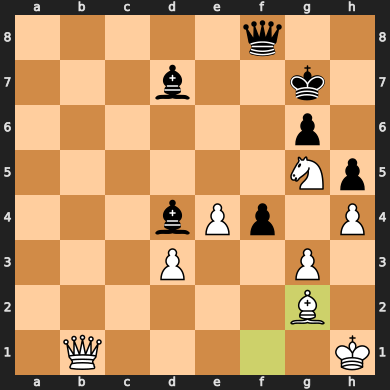

'Number of evaluations: 162'

[('f4g3', 0.59053296),
 ('d7g4', 0.37162107),
 ('f4f3', 0.32783404),
 ('f8a3', 0.29761842),
 ('d4e3', 0.28365391),
 ('f8f6', 0.26649505),
 ('d4e5', 0.2342085),
 ('d4f2', 0.1738982)]

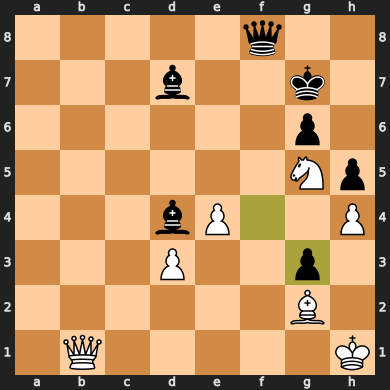

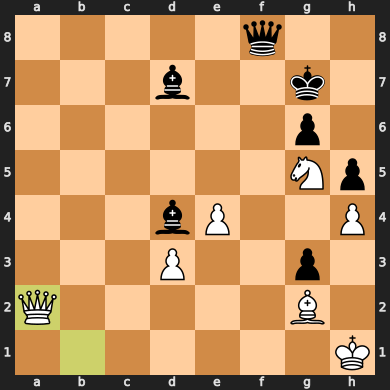

'Number of evaluations: 154'

[('f8f4', 0.7319577),
 ('f8f2', 0.6751937),
 ('d7g4', 0.58270055),
 ('f8f6', 0.5787637),
 ('f8b4', 0.56427467),
 ('d4e3', 0.46356195),
 ('d4c3', 0.4495984),
 ('d4e5', 0.3888196)]

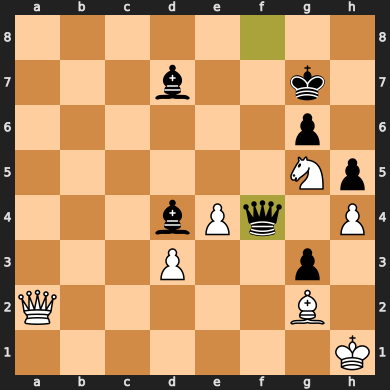

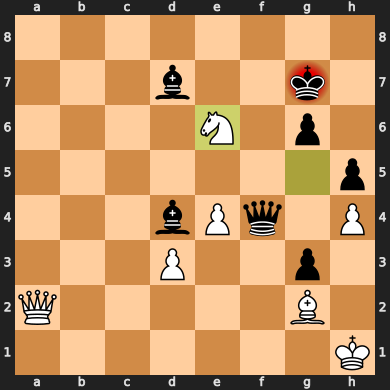

'Number of evaluations: 295'

[('d7e6', 0.98013616),
 ('g7h8', 0.10237391),
 ('g7h6', 0.08635246),
 ('g7h7', 0.07811928),
 ('g7f6', 0.0741695),
 ('g7f7', 0.07361044),
 ('g7g8', 0.06733582)]

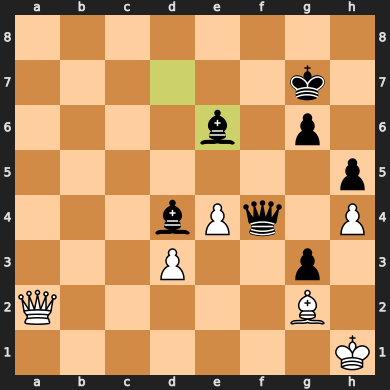

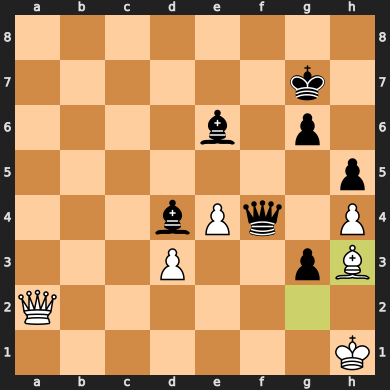

'Number of evaluations: 311'

[('e6a2', 0.9999068),
 ('e6h3', 0.9998454),
 ('e6g4', 0.9797632),
 ('f4e4', 0.9559274),
 ('f4h4', 0.83792263),
 ('d4e3', 0.64620024),
 ('d4c3', 0.6084692),
 ('f4f2', 0.24523446)]

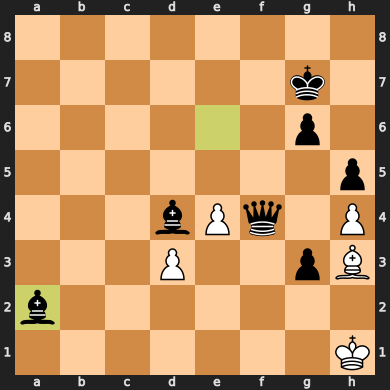

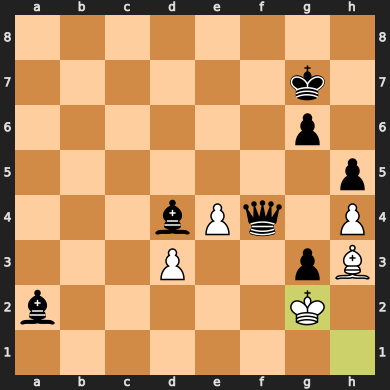

'Number of evaluations: 262'

[('f4f2', 1.0),
 ('f4d2', 0.9998708),
 ('f4h4', 0.99778557),
 ('d4e3', 0.99663603),
 ('d4f2', 0.994703),
 ('d4c3', 0.988858),
 ('f4e4', 0.9811049),
 ('f4f3', 0.93076324)]

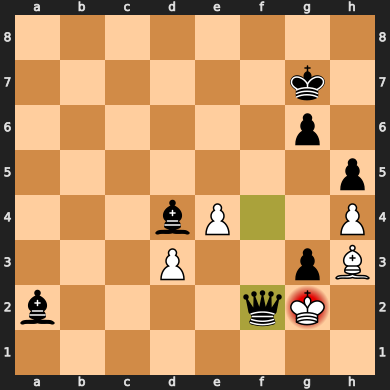

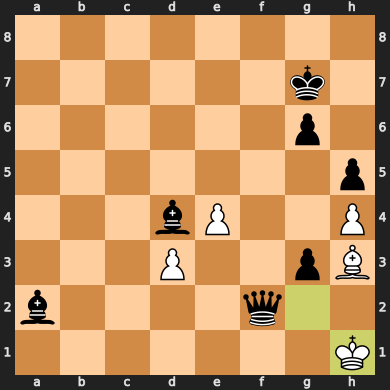

'Number of evaluations: 156'

[('f2g1', 1.0),
 ('g3g2', 1.0),
 ('f2h2', 1.0),
 ('f2f3', 0.99983275),
 ('f2e2', 0.9997149),
 ('d4e3', 0.9996922),
 ('f2d2', 0.99796873),
 ('f2c2', 0.9962537)]

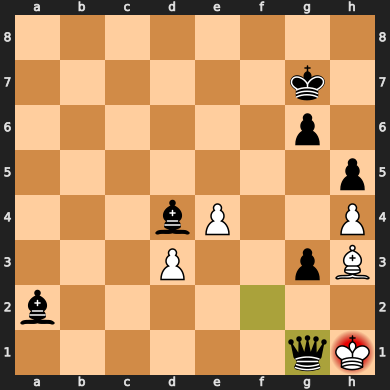

,graphchess,result,len,game,initial_fen
0,B,0-1,17,B1.e5 W1.Qa2+ B2.Kg7 W2.Qxb1 B3.exf4 W3.Bg2 B4...,5qk1/3b4/4p1p1/6Np/3bPB1P/3P2P1/4Q3/1r3B1K b -...


In [ ]:
i = 0
fens_base_history = []
gameplay = []

while True:
    current_fen_base = ' '.join(b.fen().split(' ')[:4])
    repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
    fens_base_history += [current_fen_base]

    current_color = 'w' if b.turn else 'b'

    if i % 2 == 0:
        n_evals = 1

        probas, _ = evaluate(
            predict_func=predict,
            feats_input=get_feats_input(b, state_rep=repeats),
            verbose=False, n=8, return_final_res_probas=True)
        probas = probas[['uci', 'proba']]

        if probas.shape[0] == 0 or i > 50:
            break

        values = []

        for _, (uci, proba) in probas.iterrows():
            b.push_uci(uci)
            v, count = minimax_search(b, origin_color=current_color, joint_proba=proba, proba_limit=1e-3)
            values += [(uci, v)]
            n_evals += count
            b.pop()

        values = sorted(values, key=lambda x: x[1], reverse=True)
        display(f"Number of evaluations: {n_evals}")
        display(values)
        next_move_uci = values[0][0]

    else:
        stock.set_fen_position(b.fen())
        next_move_uci = stock.get_best_move()

        if next_move_uci is None:
            break

    gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
    b.push_uci(next_move_uci)
    i += 1
    display(b)

display(pd.DataFrame([{
    'graphchess': initial_fen.split(' ')[1].upper(),
    'result': b.result(),
    'len': len(gameplay),
    'game': ' '.join(gameplay),
    'initial_fen': initial_fen,
}]))

# Benchmark vs SF [Elo 1500]

In [ ]:
stock = Stockfish(path="/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")
stock.set_elo_rating(1500)

In [ ]:
games_history = []

for j, feats in enumerate(ds.take(5)):
    b = initialize_board_from_features(feats)
    initial_fen = b.fen()

    i = 0
    fens_base_history = []
    gameplay = []
    n_evals_list = []

    while True:
        print(f"\rGame {j + 1}, Move {i + 1}", end='')

        current_fen_base = ' '.join(b.fen().split(' ')[:4])
        repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
        fens_base_history += [current_fen_base]

        current_color = 'w' if b.turn else 'b'

        if i % 2 == 0:
            n_evals = 1

            probas, _ = evaluate(
                predict_func=predict,
                feats_input=get_feats_input(b, state_rep=repeats),
                verbose=False, n=8, return_final_res_probas=True)
            probas = probas[['uci', 'proba']]

            if probas.shape[0] == 0 or i > 100:
                break

            values = []

            for _, (uci, proba) in probas.iterrows():
                b.push_uci(uci)
                v, count = minimax_search(b, origin_color=current_color, joint_proba=proba, proba_limit=1e-3)
                values += [(uci, v)]
                n_evals += count
                b.pop()

            values = sorted(values, key=lambda x: x[1], reverse=True)
            n_evals_list += [n_evals]
            next_move_uci = values[0][0]

        else:
            stock.set_fen_position(b.fen())
            next_move_uci = stock.get_best_move()

            if next_move_uci is None:
                break

        gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
        b.push_uci(next_move_uci)
        i += 1

    res = pd.DataFrame([{
        'graphchess': initial_fen.split(' ')[1].upper(),
        'n_evals_avg': np.mean(n_evals_list),
        'n_evals_med': np.median(n_evals_list),
        'n_evals_max': np.max(n_evals_list),
        'result': b.result(),
        'len': len(gameplay),
        'game': ' '.join(gameplay),
        'initial_fen': initial_fen,
    }])
    display(res)

    games_history += [res]

Game 1, Move 14

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,210.142857,185.0,339,0-1,13,B1.dxe4 W1.Bh4 B2.Rg6+ W2.Kh1 B3.Rgg2 W3.Bf2 B...,6k1/pq3pb1/4r2p/3p1Q2/3PB3/2P4P/Pr6/3RBRK1 b -...


Game 2, Move 94

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,120.531915,119.0,256,1-0,93,W1.b7 B1.Kb3 W2.b8=Q+ B2.Ka2 W3.Qg5 B3.a3 W4.Q...,3Q4/8/1P6/4K3/p7/8/k7/8 w - - 0 1


Game 3, Move 5

<ipython-input-18-b9482ff6bac7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 3, Move 30

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,161.533333,149.0,263,0-1,29,B1.Rd4 W1.Qf2 B2.Ne4 W2.Qg1 B3.Rd2 W3.Qe3 B4.Q...,1k1r4/1pq2pp1/p3pn1p/4N2P/2P2P2/P5P1/KP2Q3/2R5...


Game 4, Move 11

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,240.4,208.0,375,0-1,10,W1.f7 B1.Rxf7 W2.Kh3 B2.b1=Q W3.Re8 B3.Qb3+ W4...,1R6/8/5P2/5r2/7p/8/kp4K1/8 w - - 0 1


Game 5, Move 31

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,171.6,178.0,286,1-0,30,B1.Bxg5 W1.Nxg5 B2.hxg5 W2.Re3 B3.c5 W3.Ng4 B4...,3rr1k1/1bpnqpp1/p4b1p/1p2p1B1/1P2N3/1BPP3P/Q4P...


In [ ]:
games_s = pd.concat(games_history, axis='rows').reset_index(drop=True)
games_s.to_parquet('games_1500_1.parquet')
display(games_s)

score = (
    np.sum((games_s['graphchess'] == 'W') & (games_s['result'] == '1-0'))
    + np.sum((games_s['graphchess'] == 'B') & (games_s['result'] == '0-1'))
    + 0.5 * np.sum(games_s['result'] == '1/2-1/2')
)
print(f"Graphchess: {score}")

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,210.142857,185.0,339,0-1,13,B1.dxe4 W1.Bh4 B2.Rg6+ W2.Kh1 B3.Rgg2 W3.Bf2 B...,6k1/pq3pb1/4r2p/3p1Q2/3PB3/2P4P/Pr6/3RBRK1 b -...
1,W,120.531915,119.0,256,1-0,93,W1.b7 B1.Kb3 W2.b8=Q+ B2.Ka2 W3.Qg5 B3.a3 W4.Q...,3Q4/8/1P6/4K3/p7/8/k7/8 w - - 0 1
2,B,161.533333,149.0,263,0-1,29,B1.Rd4 W1.Qf2 B2.Ne4 W2.Qg1 B3.Rd2 W3.Qe3 B4.Q...,1k1r4/1pq2pp1/p3pn1p/4N2P/2P2P2/P5P1/KP2Q3/2R5...
3,W,240.400000,208.0,375,0-1,10,W1.f7 B1.Rxf7 W2.Kh3 B2.b1=Q W3.Re8 B3.Qb3+ W4...,1R6/8/5P2/5r2/7p/8/kp4K1/8 w - - 0 1
4,B,171.600000,178.0,286,1-0,30,B1.Bxg5 W1.Nxg5 B2.hxg5 W2.Re3 B3.c5 W3.Ng4 B4...,3rr1k1/1bpnqpp1/p4b1p/1p2p1B1/1P2N3/1BPP3P/Q4P...


Graphchess: 3.0


In [ ]:
for j, feats in enumerate(ds.take(5)):
    b = initialize_board_from_features(feats)
    initial_fen = b.fen()

    i = 0
    fens_base_history = []
    gameplay = []
    n_evals_list = []

    while True:
        print(f"\rGame {j + 1}, Move {i + 1}", end='')

        current_fen_base = ' '.join(b.fen().split(' ')[:4])
        repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
        fens_base_history += [current_fen_base]

        current_color = 'w' if b.turn else 'b'

        if i % 2 == 0:
            n_evals = 1

            probas, _ = evaluate(
                predict_func=predict,
                feats_input=get_feats_input(b, state_rep=repeats),
                verbose=False, n=8, return_final_res_probas=True)
            probas = probas[['uci', 'proba']]

            if probas.shape[0] == 0 or i > 100:
                break

            values = []

            for _, (uci, proba) in probas.iterrows():
                b.push_uci(uci)
                v, count = minimax_search(b, origin_color=current_color, joint_proba=proba, proba_limit=1e-3)
                values += [(uci, v)]
                n_evals += count
                b.pop()

            values = sorted(values, key=lambda x: x[1], reverse=True)
            n_evals_list += [n_evals]
            next_move_uci = values[0][0]

        else:
            stock.set_fen_position(b.fen())
            next_move_uci = stock.get_best_move()

            if next_move_uci is None:
                break

        gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
        b.push_uci(next_move_uci)
        i += 1

    res = pd.DataFrame([{
        'graphchess': initial_fen.split(' ')[1].upper(),
        'n_evals_avg': np.mean(n_evals_list),
        'n_evals_med': np.median(n_evals_list),
        'n_evals_max': np.max(n_evals_list),
        'result': b.result(),
        'len': len(gameplay),
        'game': ' '.join(gameplay),
        'initial_fen': initial_fen,
    }])
    display(res)

    games_history += [res]

Game 1, Move 85

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,208.666667,194.5,378,0-1,84,W1.Rc1 B1.Re8 W2.cxd5 B2.exd5 W3.e4 B3.dxe4 W4...,r2q1rk1/pb1n1ppp/1p1bpn2/2pp4/2PP4/1P3NP1/PB1N...


Game 2, Move 17

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 103

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,255.745098,235.0,397,*,102,W1.Qe5+ B1.f6 W2.Qf4 B2.Qe7 W3.Kh2 B3.Qd7 W4.Q...,8/1p1q1pk1/p5p1/2P4p/1P5P/P3Q3/6P1/6K1 w - - 0 1


Game 3, Move 15

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 3, Move 23

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 3, Move 29

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,306.785714,299.5,432,0-1,28,W1.hxg5 B1.e2 W2.Kg4 B2.hxg5 W3.Bd4 B3.f3 W4.K...,8/1N4B1/4k2p/6p1/1P3p1P/4p2K/2r5/8 w - - 0 1


Game 4, Move 17

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 4, Move 75

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 4, Move 79

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,252.0,231.0,432,1-0,78,B1.Bb4+ W1.c3 B2.exd4 W2.cxb4 B3.Qe7 W3.Be2 B4...,r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNB...


Game 5, Move 25

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,288.416667,276.0,365,1-0,24,B1.c5 W1.e3 B2.Nc6 W2.dxc5 B3.Bg7 W3.Nc3 B4.e5...,rnbqkb1r/ppp1pp1p/5p2/3p4/2PP4/8/PP2PPPP/RN1QK...


In [ ]:
games_s = pd.concat(games_history, axis='rows').reset_index(drop=True)
games_s.to_parquet('games_1500_2.parquet')
display(games_s)

score = (
    np.sum((games_s['graphchess'] == 'W') & (games_s['result'] == '1-0'))
    + np.sum((games_s['graphchess'] == 'B') & (games_s['result'] == '0-1'))
    + 0.5 * np.sum(games_s['result'] == '1/2-1/2')
)
print(f"Graphchess: {score}")

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,210.142857,185.0,339,0-1,13,B1.dxe4 W1.Bh4 B2.Rg6+ W2.Kh1 B3.Rgg2 W3.Bf2 B...,6k1/pq3pb1/4r2p/3p1Q2/3PB3/2P4P/Pr6/3RBRK1 b -...
1,W,120.531915,119.0,256,1-0,93,W1.b7 B1.Kb3 W2.b8=Q+ B2.Ka2 W3.Qg5 B3.a3 W4.Q...,3Q4/8/1P6/4K3/p7/8/k7/8 w - - 0 1
2,B,161.533333,149.0,263,0-1,29,B1.Rd4 W1.Qf2 B2.Ne4 W2.Qg1 B3.Rd2 W3.Qe3 B4.Q...,1k1r4/1pq2pp1/p3pn1p/4N2P/2P2P2/P5P1/KP2Q3/2R5...
3,W,240.400000,208.0,375,0-1,10,W1.f7 B1.Rxf7 W2.Kh3 B2.b1=Q W3.Re8 B3.Qb3+ W4...,1R6/8/5P2/5r2/7p/8/kp4K1/8 w - - 0 1
4,B,171.600000,178.0,286,1-0,30,B1.Bxg5 W1.Nxg5 B2.hxg5 W2.Re3 B3.c5 W3.Ng4 B4...,3rr1k1/1bpnqpp1/p4b1p/1p2p1B1/1P2N3/1BPP3P/Q4P...
5,W,208.666667,194.5,378,0-1,84,W1.Rc1 B1.Re8 W2.cxd5 B2.exd5 W3.e4 B3.dxe4 W4...,r2q1rk1/pb1n1ppp/1p1bpn2/2pp4/2PP4/1P3NP1/PB1N...
6,W,255.745098,235.0,397,*,102,W1.Qe5+ B1.f6 W2.Qf4 B2.Qe7 W3.Kh2 B3.Qd7 W4.Q...,8/1p1q1pk1/p5p1/2P4p/1P5P/P3Q3/6P1/6K1 w - - 0 1
7,W,306.785714,299.5,432,0-1,28,W1.hxg5 B1.e2 W2.Kg4 B2.hxg5 W3.Bd4 B3.f3 W4.K...,8/1N4B1/4k2p/6p1/1P3p1P/4p2K/2r5/8 w - - 0 1
8,B,252.000000,231.0,432,1-0,78,B1.Bb4+ W1.c3 B2.exd4 W2.cxb4 B3.Qe7 W3.Be2 B4...,r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNB...
9,B,288.416667,276.0,365,1-0,24,B1.c5 W1.e3 B2.Nc6 W2.dxc5 B3.Bg7 W3.Nc3 B4.e5...,rnbqkb1r/ppp1pp1p/5p2/3p4/2PP4/8/PP2PPPP/RN1QK...


Graphchess: 3.0


In [ ]:
for j, feats in enumerate(ds.take(5)):
    b = initialize_board_from_features(feats)
    initial_fen = b.fen()

    i = 0
    fens_base_history = []
    gameplay = []
    n_evals_list = []

    while True:
        print(f"\rGame {j + 1}, Move {i + 1}", end='')

        current_fen_base = ' '.join(b.fen().split(' ')[:4])
        repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
        fens_base_history += [current_fen_base]

        current_color = 'w' if b.turn else 'b'

        if i % 2 == 0:
            n_evals = 1

            probas, _ = evaluate(
                predict_func=predict,
                feats_input=get_feats_input(b, state_rep=repeats),
                verbose=False, n=8, return_final_res_probas=True)
            probas = probas[['uci', 'proba']]

            if probas.shape[0] == 0 or i > 100:
                break

            values = []

            for _, (uci, proba) in probas.iterrows():
                b.push_uci(uci)
                v, count = minimax_search(b, origin_color=current_color, joint_proba=proba, proba_limit=1e-3)
                values += [(uci, v)]
                n_evals += count
                b.pop()

            values = sorted(values, key=lambda x: x[1], reverse=True)
            n_evals_list += [n_evals]
            next_move_uci = values[0][0]

        else:
            stock.set_fen_position(b.fen())
            next_move_uci = stock.get_best_move()

            if next_move_uci is None:
                break

        gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
        b.push_uci(next_move_uci)
        i += 1

    res = pd.DataFrame([{
        'graphchess': initial_fen.split(' ')[1].upper(),
        'n_evals_avg': np.mean(n_evals_list),
        'n_evals_med': np.median(n_evals_list),
        'n_evals_max': np.max(n_evals_list),
        'result': b.result(),
        'len': len(gameplay),
        'game': ' '.join(gameplay),
        'initial_fen': initial_fen,
    }])
    display(res)

    games_history += [res]

Game 1, Move 7

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 1, Move 19

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 1, Move 53

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,223.615385,225.5,320,1-0,52,B1.Nc6 W1.f3 B2.h6 W2.Bh4 B3.d5 W3.e5 B4.Nxe5 ...,rnbq1rk1/pp1p1ppp/4pn2/2p3B1/2PPP3/P1P5/5PPP/R...


Game 2, Move 41

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 43

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 49

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 51

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 53

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 73

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,279.833333,280.5,485,1-0,72,B1.Nd5 W1.Bg4 B2.hxg4 W2.Rh8 B3.gxf3 W3.gxf3 B...,8/4n3/5kp1/4p2p/8/5PKB/3r2PR/8 b - - 1 1


Game 3, Move 55

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 3, Move 63

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,207.870968,202.0,292,0-1,62,W1.Ng5 B1.Na5 W2.Qb5 B2.a6 W3.Qa4 B3.Bf4 W4.Nf...,r4rk1/ppq2ppp/2nbpn2/3p3b/3P4/1QPB1N1P/PP1N1PP...


Game 4, Move 5

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 4, Move 29

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 4, Move 45

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 4, Move 75

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 4, Move 100

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,210.36,168.0,507,0-1,99,B1.Bd6 W1.Qc2 B2.Qh4+ W2.g3 B3.Qf6 W3.f4 B4.Qg...,rn3rk1/pbpp1pp1/1p2pq1p/8/1bPPP3/P1N2P2/1P2N1P...


Game 5, Move 11

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,198.8,191.0,236,0-1,10,W1.Bxd5 B1.Qc7 W2.Rd2 B2.Rxd5 W3.Re3 B3.h5 W4....,3rr1k1/pp3ppp/1qp3b1/3nN3/1P1P2Q1/PB4RP/1R3PP1...


In [ ]:
games_s = pd.concat(games_history, axis='rows').reset_index(drop=True)
games_s.to_parquet('games_1500_3.parquet')
display(games_s)

score = (
    np.sum((games_s['graphchess'] == 'W') & (games_s['result'] == '1-0'))
    + np.sum((games_s['graphchess'] == 'B') & (games_s['result'] == '0-1'))
    + 0.5 * np.sum(games_s['result'] == '1/2-1/2')
)
print(f"Graphchess: {score}")

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,210.142857,185.0,339,0-1,13,B1.dxe4 W1.Bh4 B2.Rg6+ W2.Kh1 B3.Rgg2 W3.Bf2 B...,6k1/pq3pb1/4r2p/3p1Q2/3PB3/2P4P/Pr6/3RBRK1 b -...
1,W,120.531915,119.0,256,1-0,93,W1.b7 B1.Kb3 W2.b8=Q+ B2.Ka2 W3.Qg5 B3.a3 W4.Q...,3Q4/8/1P6/4K3/p7/8/k7/8 w - - 0 1
2,B,161.533333,149.0,263,0-1,29,B1.Rd4 W1.Qf2 B2.Ne4 W2.Qg1 B3.Rd2 W3.Qe3 B4.Q...,1k1r4/1pq2pp1/p3pn1p/4N2P/2P2P2/P5P1/KP2Q3/2R5...
3,W,240.400000,208.0,375,0-1,10,W1.f7 B1.Rxf7 W2.Kh3 B2.b1=Q W3.Re8 B3.Qb3+ W4...,1R6/8/5P2/5r2/7p/8/kp4K1/8 w - - 0 1
4,B,171.600000,178.0,286,1-0,30,B1.Bxg5 W1.Nxg5 B2.hxg5 W2.Re3 B3.c5 W3.Ng4 B4...,3rr1k1/1bpnqpp1/p4b1p/1p2p1B1/1P2N3/1BPP3P/Q4P...
5,W,208.666667,194.5,378,0-1,84,W1.Rc1 B1.Re8 W2.cxd5 B2.exd5 W3.e4 B3.dxe4 W4...,r2q1rk1/pb1n1ppp/1p1bpn2/2pp4/2PP4/1P3NP1/PB1N...
6,W,255.745098,235.0,397,*,102,W1.Qe5+ B1.f6 W2.Qf4 B2.Qe7 W3.Kh2 B3.Qd7 W4.Q...,8/1p1q1pk1/p5p1/2P4p/1P5P/P3Q3/6P1/6K1 w - - 0 1
7,W,306.785714,299.5,432,0-1,28,W1.hxg5 B1.e2 W2.Kg4 B2.hxg5 W3.Bd4 B3.f3 W4.K...,8/1N4B1/4k2p/6p1/1P3p1P/4p2K/2r5/8 w - - 0 1
8,B,252.000000,231.0,432,1-0,78,B1.Bb4+ W1.c3 B2.exd4 W2.cxb4 B3.Qe7 W3.Be2 B4...,r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNB...
9,B,288.416667,276.0,365,1-0,24,B1.c5 W1.e3 B2.Nc6 W2.dxc5 B3.Bg7 W3.Nc3 B4.e5...,rnbqkb1r/ppp1pp1p/5p2/3p4/2PP4/8/PP2PPPP/RN1QK...


Graphchess: 4.0


In [ ]:
for j, feats in enumerate(ds.take(5)):
    b = initialize_board_from_features(feats)
    initial_fen = b.fen()

    i = 0
    fens_base_history = []
    gameplay = []
    n_evals_list = []

    while True:
        print(f"\rGame {j + 1}, Move {i + 1}", end='')

        current_fen_base = ' '.join(b.fen().split(' ')[:4])
        repeats = len(list(filter(lambda x: x == current_fen_base, fens_base_history)))
        fens_base_history += [current_fen_base]

        current_color = 'w' if b.turn else 'b'

        if i % 2 == 0:
            n_evals = 1

            probas, _ = evaluate(
                predict_func=predict,
                feats_input=get_feats_input(b, state_rep=repeats),
                verbose=False, n=8, return_final_res_probas=True)
            probas = probas[['uci', 'proba']]

            if probas.shape[0] == 0 or i > 100:
                break

            values = []

            for _, (uci, proba) in probas.iterrows():
                b.push_uci(uci)
                v, count = minimax_search(b, origin_color=current_color, joint_proba=proba, proba_limit=1e-3)
                values += [(uci, v)]
                n_evals += count
                b.pop()

            values = sorted(values, key=lambda x: x[1], reverse=True)
            n_evals_list += [n_evals]
            next_move_uci = values[0][0]

        else:
            stock.set_fen_position(b.fen())
            next_move_uci = stock.get_best_move()

            if next_move_uci is None:
                break

        gameplay += [f"{'W' if b.turn else 'B'}{(i + 2) // 2}.{b.san(chess.Move.from_uci(next_move_uci))}"]
        b.push_uci(next_move_uci)
        i += 1

    res = pd.DataFrame([{
        'graphchess': initial_fen.split(' ')[1].upper(),
        'n_evals_avg': np.mean(n_evals_list),
        'n_evals_med': np.median(n_evals_list),
        'n_evals_max': np.max(n_evals_list),
        'result': b.result(),
        'len': len(gameplay),
        'game': ' '.join(gameplay),
        'initial_fen': initial_fen,
    }])
    display(res)

    games_history += [res]

Game 1, Move 21

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,166.0,162.5,212,1-0,20,B1.bxa4 W1.Qe4 B2.Qd6 W2.c4 B3.g6 W3.Bg4 B4.a3...,r1b2qr1/p5pQ/2p1pk1p/1p1n3B/P2P4/2P5/5PPP/R1B1...


Game 2, Move 13

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 19

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 2, Move 45

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,183.136364,174.0,295,1-0,44,B1.a6 W1.Rf2 B2.b5 W2.Nf1 B3.b4 W3.Qa4 B4.Bxf4...,r2qk2r/pp3ppp/2nbpn2/3p3b/3P1B2/2PB1P2/PP1NN1P...


Game 3, Move 19

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 3, Move 101

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 3, Move 103

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,219.058824,213.0,456,*,102,B1.Ng4 W1.h3 B2.f5 W2.hxg4 B3.fxg4 W3.e3 B4.cx...,r2q1rk1/1p2npb1/2ppbnpp/1P2p3/2P5/2NP2P1/1B1NP...


Game 4, Move 5

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,251.5,251.5,259,1-0,4,B1.c4 W1.Qf3 B2.cxd3 W2.Qxf7#,rn1qkb1r/1b1n1ppp/p3p3/1pppP1N1/3P4/2PB4/PP3PP...


Game 5, Move 63

<ipython-input-49-b7ada348e462>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probas['proba'] *= joint_proba


Game 5, Move 99

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,W,284.367347,234.0,546,0-1,98,W1.Ke2 B1.h5 W2.Ba5 B2.b6 W3.Bd2 B3.Nc7 W4.Bg5...,7r/pp1k1pb1/3p2pp/3n4/3P4/5N2/PP1B1PPP/2R2K2 w...


In [ ]:
games_s = pd.concat(games_history, axis='rows').reset_index(drop=True)
games_s.to_parquet('games_1500_4.parquet')
display(games_s)

score = (
    np.sum((games_s['graphchess'] == 'W') & (games_s['result'] == '1-0'))
    + np.sum((games_s['graphchess'] == 'B') & (games_s['result'] == '0-1'))
    + 0.5 * np.sum(games_s['result'] == '1/2-1/2')
)
print(f"Graphchess: {score}")

,graphchess,n_evals_avg,n_evals_med,n_evals_max,result,len,game,initial_fen
0,B,210.142857,185.0,339,0-1,13,B1.dxe4 W1.Bh4 B2.Rg6+ W2.Kh1 B3.Rgg2 W3.Bf2 B...,6k1/pq3pb1/4r2p/3p1Q2/3PB3/2P4P/Pr6/3RBRK1 b -...
1,W,120.531915,119.0,256,1-0,93,W1.b7 B1.Kb3 W2.b8=Q+ B2.Ka2 W3.Qg5 B3.a3 W4.Q...,3Q4/8/1P6/4K3/p7/8/k7/8 w - - 0 1
2,B,161.533333,149.0,263,0-1,29,B1.Rd4 W1.Qf2 B2.Ne4 W2.Qg1 B3.Rd2 W3.Qe3 B4.Q...,1k1r4/1pq2pp1/p3pn1p/4N2P/2P2P2/P5P1/KP2Q3/2R5...
3,W,240.400000,208.0,375,0-1,10,W1.f7 B1.Rxf7 W2.Kh3 B2.b1=Q W3.Re8 B3.Qb3+ W4...,1R6/8/5P2/5r2/7p/8/kp4K1/8 w - - 0 1
4,B,171.600000,178.0,286,1-0,30,B1.Bxg5 W1.Nxg5 B2.hxg5 W2.Re3 B3.c5 W3.Ng4 B4...,3rr1k1/1bpnqpp1/p4b1p/1p2p1B1/1P2N3/1BPP3P/Q4P...
5,W,208.666667,194.5,378,0-1,84,W1.Rc1 B1.Re8 W2.cxd5 B2.exd5 W3.e4 B3.dxe4 W4...,r2q1rk1/pb1n1ppp/1p1bpn2/2pp4/2PP4/1P3NP1/PB1N...
6,W,255.745098,235.0,397,*,102,W1.Qe5+ B1.f6 W2.Qf4 B2.Qe7 W3.Kh2 B3.Qd7 W4.Q...,8/1p1q1pk1/p5p1/2P4p/1P5P/P3Q3/6P1/6K1 w - - 0 1
7,W,306.785714,299.5,432,0-1,28,W1.hxg5 B1.e2 W2.Kg4 B2.hxg5 W3.Bd4 B3.f3 W4.K...,8/1N4B1/4k2p/6p1/1P3p1P/4p2K/2r5/8 w - - 0 1
8,B,252.000000,231.0,432,1-0,78,B1.Bb4+ W1.c3 B2.exd4 W2.cxb4 B3.Qe7 W3.Be2 B4...,r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNB...
9,B,288.416667,276.0,365,1-0,24,B1.c5 W1.e3 B2.Nc6 W2.dxc5 B3.Bg7 W3.Nc3 B4.e5...,rnbqkb1r/ppp1pp1p/5p2/3p4/2PP4/8/PP2PPPP/RN1QK...


Graphchess: 4.0


In [ ]:
PATH = DRIVE_PATH.format('2')
games_s.to_parquet('games_search_vs_sf_1500elo.parquet')
run_cmd(f'cp games_search_vs_sf_1500elo.parquet "{PATH}"')